In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [6]:
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 22.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 607kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 5.61MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.09MB/s]


In [7]:
def add_noise(inputs, noise_factor=0.5):
    noisy = inputs + noise_factor * torch.randn_like(inputs)
    return torch.clamp(noisy, 0., 1.)


In [8]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # [B, 16, 14, 14]
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), # [B, 32, 7, 7]
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, output_padding=1, padding=1), # [B, 16, 14, 14]
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, output_padding=1, padding=1),  # [B, 1, 28, 28]
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [9]:
model = DenoisingAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [10]:
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 14, 14]             160
              ReLU-2           [-1, 16, 14, 14]               0
            Conv2d-3             [-1, 32, 7, 7]           4,640
              ReLU-4             [-1, 32, 7, 7]               0
   ConvTranspose2d-5           [-1, 16, 14, 14]           4,624
              ReLU-6           [-1, 16, 14, 14]               0
   ConvTranspose2d-7            [-1, 1, 28, 28]             145
           Sigmoid-8            [-1, 1, 28, 28]               0
Total params: 9,569
Trainable params: 9,569
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.13
Params size (MB): 0.04
Estimated Total Size (MB): 0.17
----------------------------------------------------------------


In [11]:
def train(model, loader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, _ in loader:
            images = images.to(device)
            noisy_images = add_noise(images).to(device)

            # Forward pass
            outputs = model(noisy_images)
            loss = criterion(outputs, images)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(loader):.4f}")

In [12]:
def visualize_denoising(model, loader, num_images=10):
    model.eval()
    with torch.no_grad():
        for images, _ in loader:
            images = images.to(device)
            noisy_images = add_noise(images).to(device)
            outputs = model(noisy_images)
            break

    images = images.cpu().numpy()
    noisy_images = noisy_images.cpu().numpy()
    outputs = outputs.cpu().numpy()

    print("Name: SIVABALAN S")
    print("Register Number: 212222240100")
    plt.figure(figsize=(18, 6))
    for i in range(num_images):
        # Original
        ax = plt.subplot(3, num_images, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        ax.set_title("Original")
        plt.axis("off")

        # Noisy
        ax = plt.subplot(3, num_images, i + 1 + num_images)
        plt.imshow(noisy_images[i].squeeze(), cmap='gray')
        ax.set_title("Noisy")
        plt.axis("off")

        # Denoised
        ax = plt.subplot(3, num_images, i + 1 + 2 * num_images)
        plt.imshow(outputs[i].squeeze(), cmap='gray')
        ax.set_title("Denoised")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

Epoch [1/5], Loss: 0.0667
Epoch [2/5], Loss: 0.0149
Epoch [3/5], Loss: 0.0142
Epoch [4/5], Loss: 0.0138
Epoch [5/5], Loss: 0.0136
Name: SIVABALAN S
Register Number: 212222240100


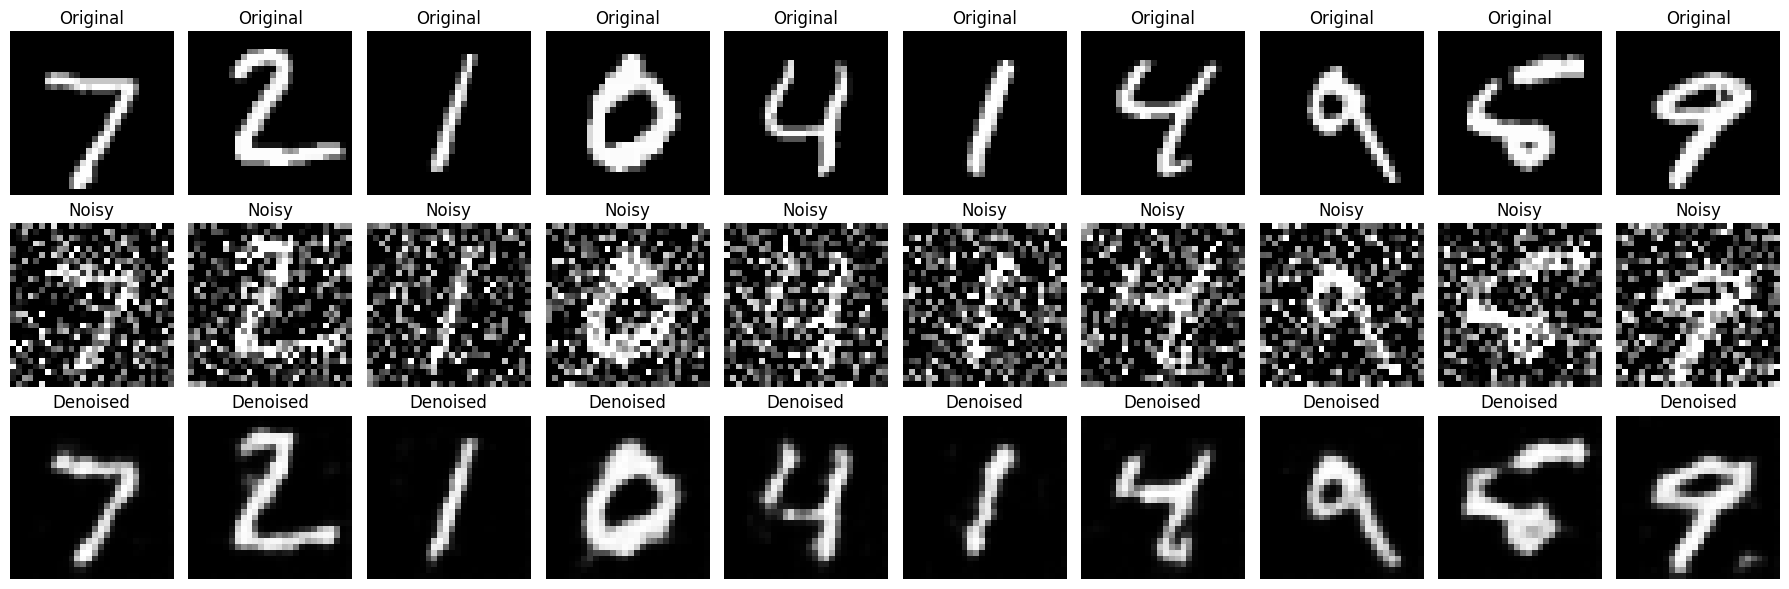

In [13]:
train(model, train_loader, criterion, optimizer, epochs=5)
visualize_denoising(model, test_loader)